In [1]:
import pandas as pd
import numpy as np
import utils
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
tracks = utils.load('../data/fma_metadata/tracks.csv')
features = utils.load('../data/fma_metadata/features.csv')

In [3]:
type(tracks), type(features)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [4]:
# https://stackoverflow.com/questions/14507794/pandas-how-to-flatten-a-hierarchical-index-in-columns
tracks.columns = ['_'.join(col) for col in tracks.columns.to_flat_index()]
features.columns = ['_'.join(col) for col in features.columns.to_flat_index()]

In [5]:
smol_tracks = tracks.loc[tracks['set_subset'] == 'small']

In [6]:
smol_tracks.shape

(8000, 52)

In [7]:
smol_tracks.head()

,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,album_tags,...,track_information,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title
track_id,,,,,,,,,,,,,,,,,,,,,
2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],...,NaN,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food
5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,[],...,NaN,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World
10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,[],...,NaN,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway
140,1,2008-11-26 01:49:59,2007-05-22,NaN,1,61,<p>Alec K. Redfearn &amp; The Eyesores: Ellen ...,1300,"Alec K. Refearn, Rob Pemberton",[],...,NaN,1593,en,Attribution-Noncommercial-No Derivative Works ...,1299,NaN,2,NaN,[],Queen Of The Wires
141,0,2008-11-26 01:49:57,2009-01-16,NaN,1,60,"<p>A full ensamble of strings, drums, electron...",1304,NaN,[],...,NaN,839,en,Attribution-Noncommercial-No Derivative Works ...,725,NaN,4,NaN,[],Ohio


In [10]:
smol_tracks.isna().sum().sort_values(ascending=False)[:25]

track_lyricist              7974
track_publisher             7924
track_information           7841
track_composer              7820
artist_active_year_end      7642
artist_wikipedia_page       7590
track_date_recorded         7535
artist_related_projects     7306
artist_associated_labels    7151
track_language_code         6995
album_engineer              6858
album_producer              6596
artist_active_year_begin    6458
artist_longitude            5101
artist_latitude             5101
artist_members              4475
album_date_released         2663
artist_location             2529
artist_bio                  2086
artist_website              1548
album_information           1498
album_type                   231
track_license                  5
track_interest                 0
track_genres_all               0
dtype: int64

In [11]:
features.head()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.054125,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.063831,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.000000,1.716724,0.069330
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.040730,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.074358,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800
20,-0.193837,-0.198527,0.201546,0.258556,0.775204,0.084794,-0.289294,-0.816410,0.043851,-0.804761,...,0.095003,0.022492,0.021355,16.669037,0.469727,0.047225,0.040039,0.000977,3.189831,0.030993


In [12]:
features.isnull().sum().sort_values(ascending=False)

chroma_cens_kurtosis_01    0
mfcc_median_13             0
mfcc_skew_03               0
mfcc_skew_02               0
mfcc_skew_01               0
                          ..
chroma_cqt_std_12          0
chroma_cqt_std_11          0
chroma_cqt_std_10          0
chroma_cqt_std_09          0
zcr_std_01                 0
Length: 518, dtype: int64

In [13]:
track_meta = ['track_genre_top', 'track_title', 'artist_name']

In [14]:
df = features.merge(smol_tracks[track_meta],
                    left_index=True, right_index=True)

In [15]:
df.head()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01,track_genre_top,track_title,artist_name
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,5.758890,0.459473,0.085629,0.071289,0.000000,2.089872,0.061448,Hip-Hop,Food,AWOL
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,6.808415,0.375000,0.053114,0.041504,0.000000,2.193303,0.044861,Hip-Hop,This World,AWOL
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,21.434212,0.452148,0.077515,0.071777,0.000000,3.542325,0.040800,Pop,Freeway,Kurt Vile
140,0.533579,-0.623885,-1.086205,-1.081079,-0.765151,-0.072282,-0.882913,-0.582376,-0.884749,-0.645214,...,11.052547,0.379395,0.052379,0.036621,0.001953,3.143968,0.057712,Folk,Queen Of The Wires,Alec K. Redfearn & the Eyesores
141,0.172898,-0.284804,-1.169662,-1.062855,-0.706868,-0.708281,-0.204884,0.023624,-0.642770,-0.786291,...,32.994659,0.415527,0.040267,0.034668,0.002930,4.204097,0.028665,Folk,Ohio,Alec K. Redfearn & the Eyesores


In [16]:
for dtype in df.dtypes:
    if dtype != np.number:
        print(dtype)

category
object
object


<ipython-input-16-6ed53c4ae0e6>:2: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if dtype != np.number:


In [17]:
df.index = df.index.astype('string')

In [18]:
df.to_csv('../data/features_with_genres.csv')

In [19]:
corr = df.corr()

In [20]:
len(corr.values.flatten())

268324

In [21]:
corr_values = [value for value in corr.values.flatten() if value != 1]
max(corr_values)

0.9955111394165266

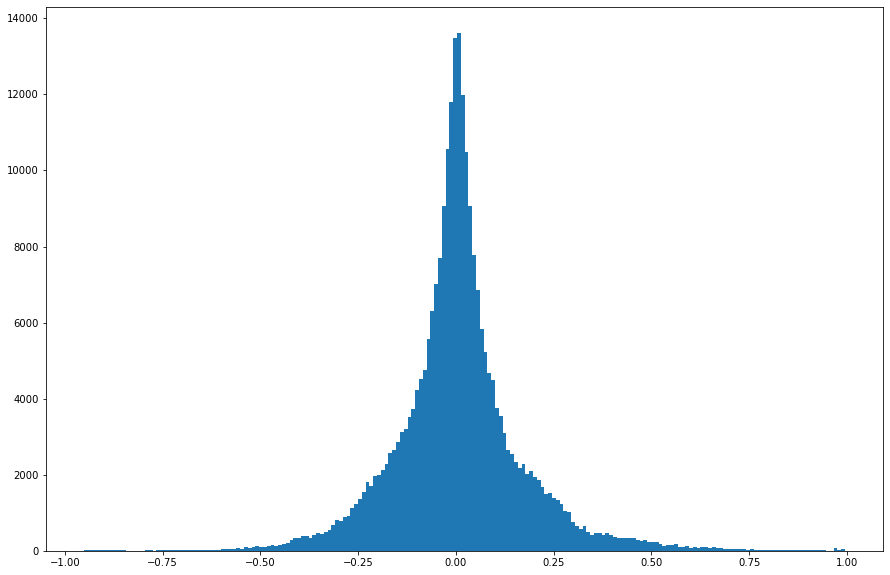

In [22]:
plt.figure(figsize = (15,10))
plt.hist(corr_values, bins=200);

In [23]:
df.describe()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,...,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,0.111983,0.007180,0.200494,0.005261,0.067485,0.077369,0.021349,0.139799,0.012609,0.091662,...,0.103515,0.021801,0.022063,31.577011,0.395773,0.050856,0.041552,0.002503,3.519118,0.040383
std,1.656377,1.934319,6.073813,1.288859,1.636802,1.599574,2.086226,2.983964,1.810619,1.984203,...,0.036906,0.005843,0.005811,70.380338,0.185470,0.028484,0.027080,0.004689,2.962467,0.025868
min,-1.803165,-1.816620,-1.825738,-1.760243,-1.781202,-1.718097,-1.778957,-1.745497,-1.802878,-1.787692,...,0.014479,0.006234,0.006667,-1.790083,0.032715,0.003490,0.000000,0.000000,-3.143864,0.002608
25%,-0.695236,-0.732614,-0.691606,-0.698568,-0.722502,-0.695780,-0.738476,-0.696258,-0.734161,-0.724942,...,0.076203,0.017550,0.017851,4.452607,0.261719,0.032412,0.024414,0.000000,1.647383,0.022612
50%,-0.225979,-0.288605,-0.217185,-0.265719,-0.267887,-0.230598,-0.309080,-0.241916,-0.306807,-0.255516,...,0.099103,0.020881,0.021280,12.284789,0.368652,0.046102,0.036621,0.000977,2.721854,0.033839
75%,0.426059,0.326636,0.447804,0.339266,0.387846,0.411859,0.323601,0.434207,0.324868,0.402692,...,0.125883,0.025197,0.025516,32.293960,0.482422,0.062770,0.052246,0.003418,4.601721,0.051452
max,42.851593,79.781960,517.172424,26.313240,43.405674,47.604107,101.148888,188.753738,74.518082,75.878792,...,0.279182,0.058427,0.071633,1575.385254,0.999512,0.629665,0.749512,0.170898,36.000904,0.317725


In [32]:
X = df.drop(columns=track_meta)
y = df['track_genre_top']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                   random_state=42)

In [33]:
ss = StandardScaler()
ss.fit(X_train)
X_train_sc = ss.transform(X_train)
X_test_sc = ss.transform(X_test)

In [40]:
forest = RandomForestClassifier(max_depth = 3, n_estimators = 1000)
forest.fit(X_train_sc, y_train)
forest.score(X_test_sc, y_test), forest.score(X_train_sc, y_train)

(0.4185, 0.44416666666666665)

In [ ]:
X_train.shape

In [ ]:
y_train.value_counts(normalize=True)

In [27]:
X_train.head()

,chroma_cens_kurtosis_01,chroma_cens_kurtosis_02,chroma_cens_kurtosis_03,chroma_cens_kurtosis_04,chroma_cens_kurtosis_05,chroma_cens_kurtosis_06,chroma_cens_kurtosis_07,chroma_cens_kurtosis_08,chroma_cens_kurtosis_09,chroma_cens_kurtosis_10,...,tonnetz_std_04,tonnetz_std_05,tonnetz_std_06,zcr_kurtosis_01,zcr_max_01,zcr_mean_01,zcr_median_01,zcr_min_01,zcr_skew_01,zcr_std_01
track_id,,,,,,,,,,,,,,,,,,,,,
13201,0.420879,-0.822415,-0.853196,0.464956,3.814499,0.425468,-0.947115,-1.060195,-0.475784,-0.689962,...,0.105723,0.018722,0.019031,12.586129,0.429199,0.062467,0.055664,0.0,2.446809,0.045005
112585,-0.672624,-0.335451,-0.110136,-0.218467,0.169417,0.010902,0.672023,0.139868,-0.694096,-0.767099,...,0.058745,0.017428,0.017723,7.194702,0.481934,0.076092,0.059570,0.0,2.291025,0.060461
119979,-0.876021,-0.795852,-0.918822,-1.041375,-0.998280,-0.886390,-0.382970,0.392757,-0.258268,-0.598918,...,0.047526,0.016716,0.010916,3.456737,0.495117,0.079870,0.044922,0.0,1.957966,0.101695
60331,11.559152,12.706867,-1.306750,-1.148779,-1.239072,2.460004,3.498828,5.826253,8.835379,13.576900,...,0.087272,0.020342,0.013623,-0.644161,0.343262,0.085409,0.095215,0.0,0.038523,0.058724
113260,-0.768486,-0.760685,0.382141,-0.374696,-0.447805,-1.324002,-0.983642,0.612836,-0.132008,-0.511389,...,0.125314,0.028787,0.028133,8.704784,0.206055,0.034916,0.029297,0.0,2.401070,0.024702


In [42]:
518**.5

22.759613353482084

In [53]:
gbm = GradientBoostingClassifier(min_samples_split = 10, subsample = 1,
                                 max_features = 'sqrt', n_iter_no_change = 5,
                                 n_estimators = 500, learning_rate = .0001,
                                 tol = .0001, verbose=1)
gbm.fit(X_train, y_train)
gbm.score(X_test, y_test), gbm.score(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           2.0793            1.95m
         2           2.0792            1.96m
         3           2.0791            1.95m
         4           2.0790            1.94m
         5           2.0789            1.93m
         6           2.0789            1.93m
         7           2.0788            1.93m
         8           2.0787            1.93m
         9           2.0786            1.93m
        10           2.0785            1.92m
        20           2.0775            1.88m
        30           2.0766            1.84m
        40           2.0756            1.80m
        50           2.0747            1.76m
        60           2.0737            1.72m
        70           2.0728            1.68m
        80           2.0718            1.64m
        90           2.0709            1.60m
       100           2.0700            1.56m
       200           2.0607            1.16m
       300           2.0516           46.51s
       40

(0.473, 0.5468333333333333)

In [55]:
(gbm.predict(X_test) == y_test).mean()

0.473

In [ ]:
lr = LogisticRegression(penalty = 'l1', solver = 'saga', C = .01, max_iter = 1000)
lr.fit(X_train_sc, y_train)

In [128]:
lr.score(X_test_sc, y_test)

0.5175

In [97]:
518**.5

22.759613353482084

In [31]:
pca = PCA()
pca.fit(X_train_sc)

NameError: name 'X_train_sc' is not defined

In [26]:
sum([round(val, 5) for val in pca.explained_variance_ratio_][:100])

0.8402800000000001

In [30]:
len(X_train)

6000

In [31]:
6000**.5

77.45966692414834

In [35]:
pca = PCA(518)
pca.fit(X_train_sc)

PCA(n_components=518)

In [38]:
X_train_pca = pd.DataFrame(pca.transform(X_train_sc))
X_test_pca = pd.DataFrame(pca.transform(X_test_sc))

In [39]:
forest = RandomForestClassifier(max_depth = 3, n_estimators = 1000, )
forest.fit(X_train_pca, y_train)
forest.score(X_test_pca, y_test), forest.score(X_train_pca, y_train)

(0.4655, 0.529)

In [41]:
lr = LogisticRegression(penalty = 'l2', solver = 'newton-cg', C = .1,
                        max_iter = 2000)
lr.fit(X_train_pca, y_train)

C:\Users\098uy\anaconda3\envs\audio_project\lib\site-packages\sklearn\utils\optimize.py:202: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


LogisticRegression(C=0.1, max_iter=2000, solver='newton-cg')

In [33]:
lr.score(X_test_pca, y_test), lr.score(X_train_pca, y_train)

0.461

In [34]:
X_train_pca.corr()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.000000,0.869717,0.989605,-0.066455,-0.762638,0.690051,0.984685,0.967710,0.993810,-0.135123,...,0.693053,-0.134249,-0.197341,0.488265,0.342641,-0.178115,-0.708233,0.245770,-0.615005,-0.968896
1,0.869717,1.000000,0.836645,0.100152,-0.381031,0.490480,0.863773,0.776463,0.902955,0.143955,...,0.692680,0.264852,-0.418829,0.208290,0.033571,-0.290078,-0.560605,-0.013195,-0.217730,-0.819967
2,0.989605,0.836645,1.000000,-0.028976,-0.781964,0.719389,0.990339,0.980730,0.981042,-0.182041,...,0.703359,-0.170538,-0.190829,0.480839,0.373230,-0.189413,-0.709672,0.257154,-0.638095,-0.959836
3,-0.066455,0.100152,-0.028976,1.000000,0.079304,0.493326,0.000518,0.046700,-0.088512,-0.280129,...,-0.119188,-0.195362,0.351053,0.237885,0.374776,0.446892,-0.359387,0.433071,-0.068335,-0.066549
4,-0.762638,-0.381031,-0.781964,0.079304,1.000000,-0.806906,-0.751332,-0.852567,-0.697163,0.632860,...,-0.334526,0.697200,-0.341937,-0.785797,-0.782731,-0.217747,0.772908,-0.683536,0.940926,0.811524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.178115,-0.290078,-0.189413,0.446892,-0.217747,0.331163,-0.240059,-0.102223,-0.239027,-0.477694,...,-0.544890,-0.686699,0.943651,0.726678,0.620621,1.000000,-0.322816,0.782070,-0.440656,-0.039854
96,-0.708233,-0.560605,-0.709672,-0.359387,0.772908,-0.914243,-0.734340,-0.805716,-0.655137,0.596355,...,-0.158241,0.476641,-0.347738,-0.749053,-0.760312,-0.322816,1.000000,-0.722081,0.708213,0.780417
97,0.245770,-0.013195,0.257154,0.433071,-0.683536,0.771754,0.237930,0.400217,0.157297,-0.831556,...,-0.193440,-0.888754,0.856691,0.887708,0.964125,0.782070,-0.722081,1.000000,-0.799842,-0.425192
98,-0.615005,-0.217730,-0.638095,-0.068335,0.940926,-0.801738,-0.584586,-0.718566,-0.540547,0.638910,...,-0.210135,0.856678,-0.540312,-0.892388,-0.850664,-0.440656,0.708213,-0.799842,1.000000,0.729589


In [11]:
y, sr = librosa.load('../data/fma_small/065/065488.mp3', sr=48000)

C:\Users\098uy\anaconda3\envs\audio_project\lib\site-packages\librosa\core\audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [73]:
len(y), 48000 * 30

(8000, 1440000)

Librosa has a default sampling rate of 22,050 hertz. Audio track is ~30s long.

In [15]:
y[50000:50020]

array([-0.11154175, -0.10891724, -0.10017395, -0.08799744, -0.0776825 ,
       -0.07331848, -0.07492065, -0.07995605, -0.08572388, -0.09016418,
       -0.09378052, -0.09928894, -0.10588074, -0.10832214, -0.10362244,
       -0.09367371, -0.08152771, -0.07066345, -0.06495667, -0.06567383],
      dtype=float32)

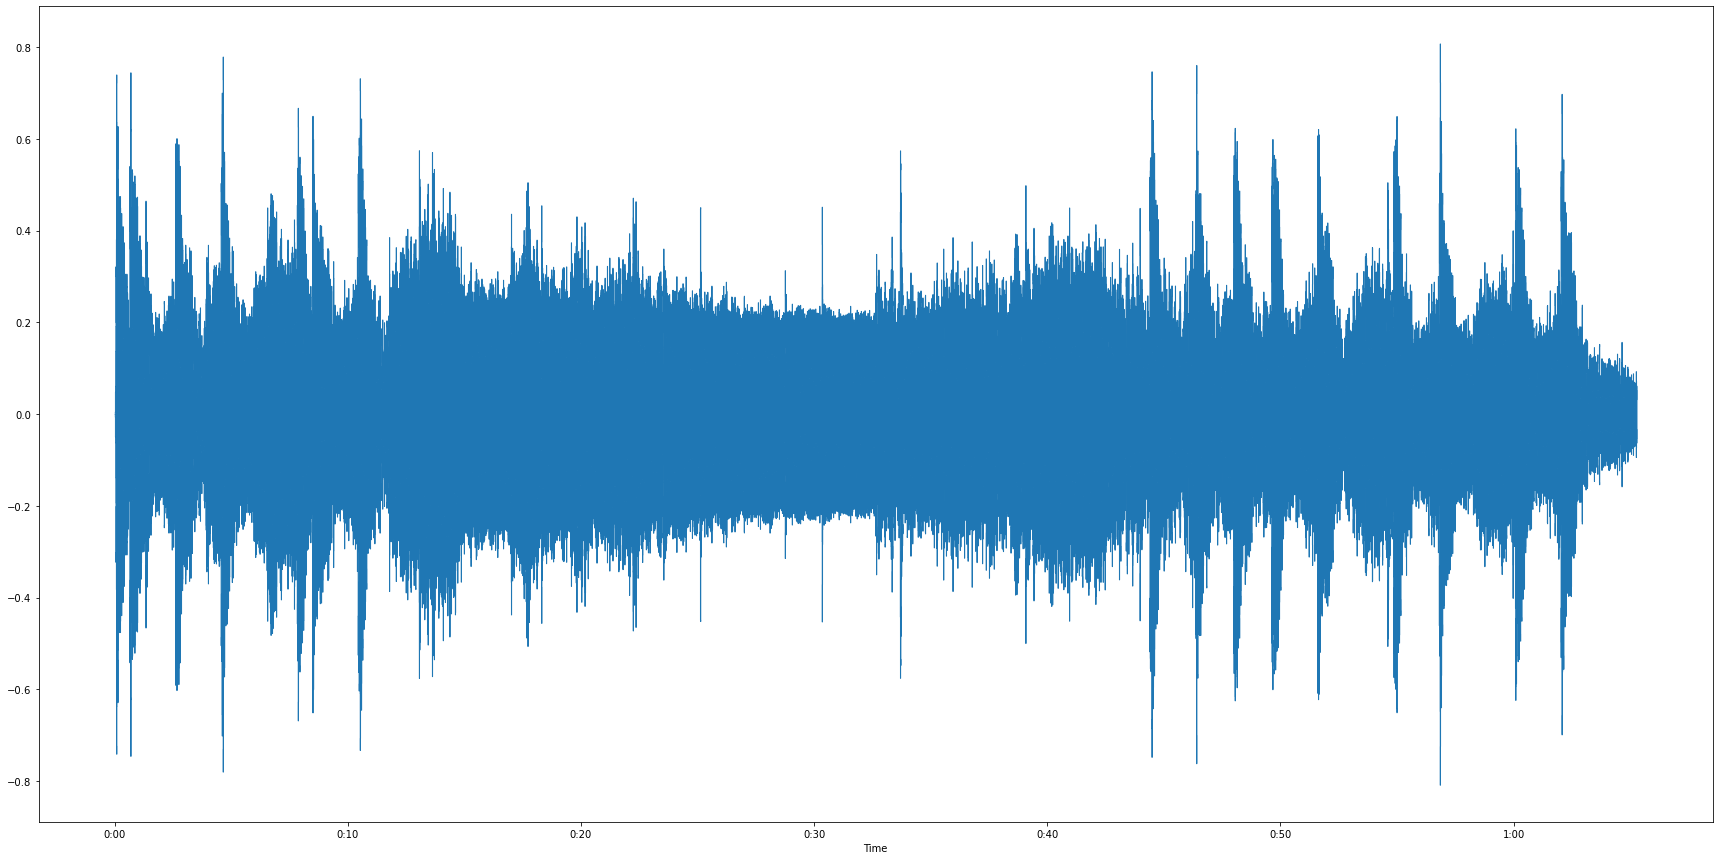

In [54]:
fig = plt.figure(figsize = (30, 15))
librosa.display.waveshow(y);

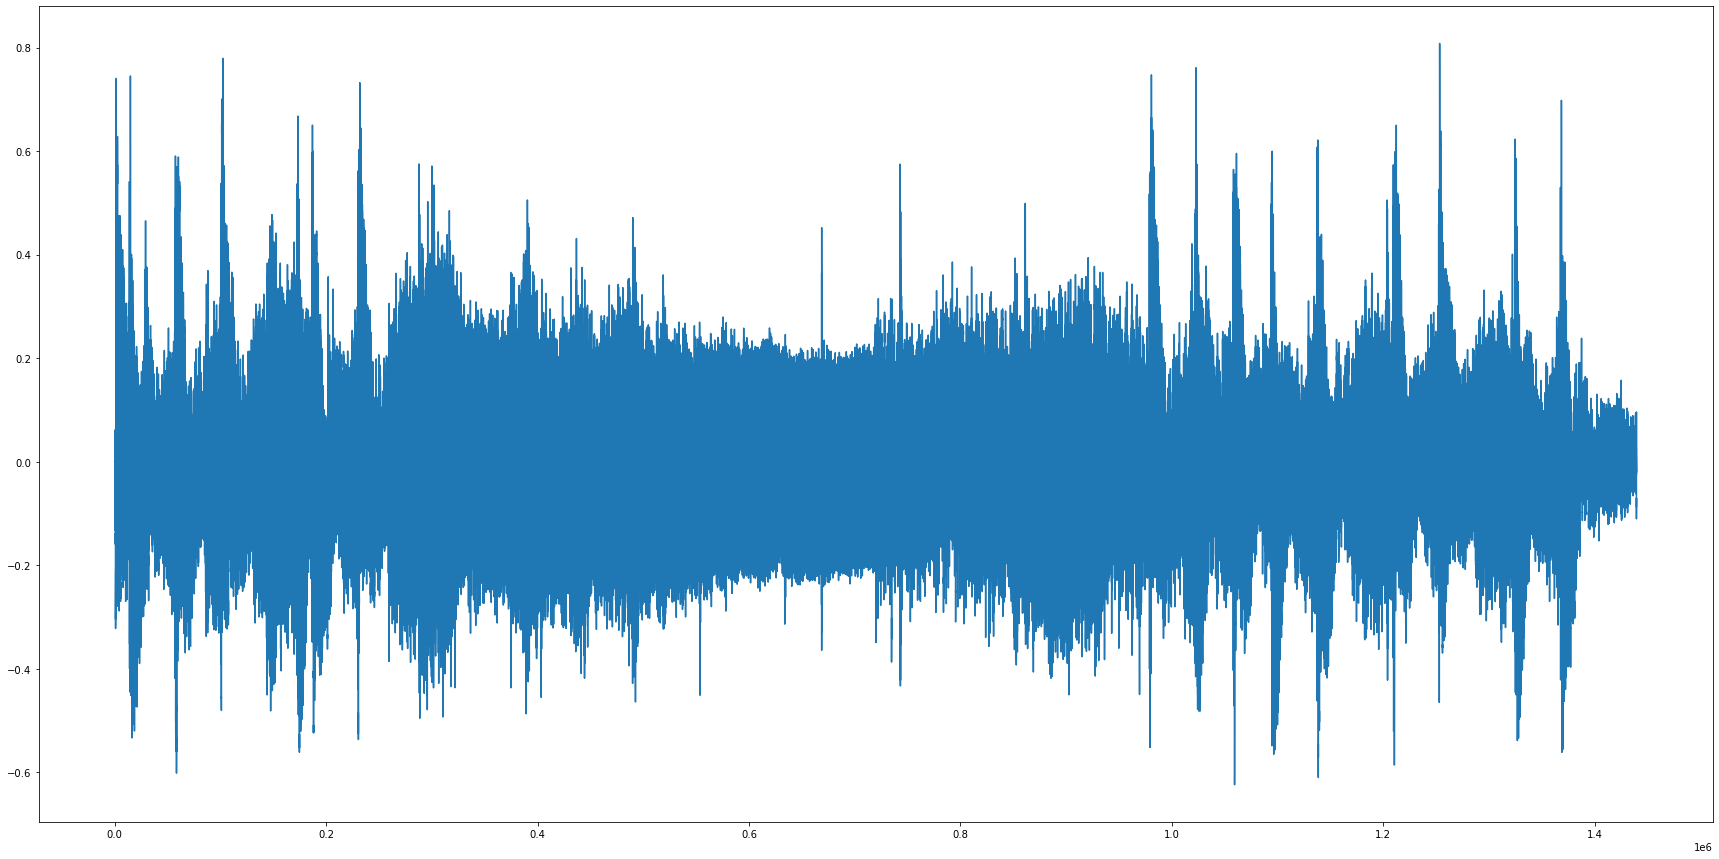

In [55]:
fig = plt.figure(figsize= (30, 15))
plt.plot(y)

In [56]:
mfcc = librosa.feature.mfcc(y, hop_length=512)

In [57]:
mfcc[0]

array([-375.26352, -303.60452, -279.19446, ..., -360.68008, -312.98932,
       -233.67032], dtype=float32)

In [58]:
mfcc.shape

(20, 2812)

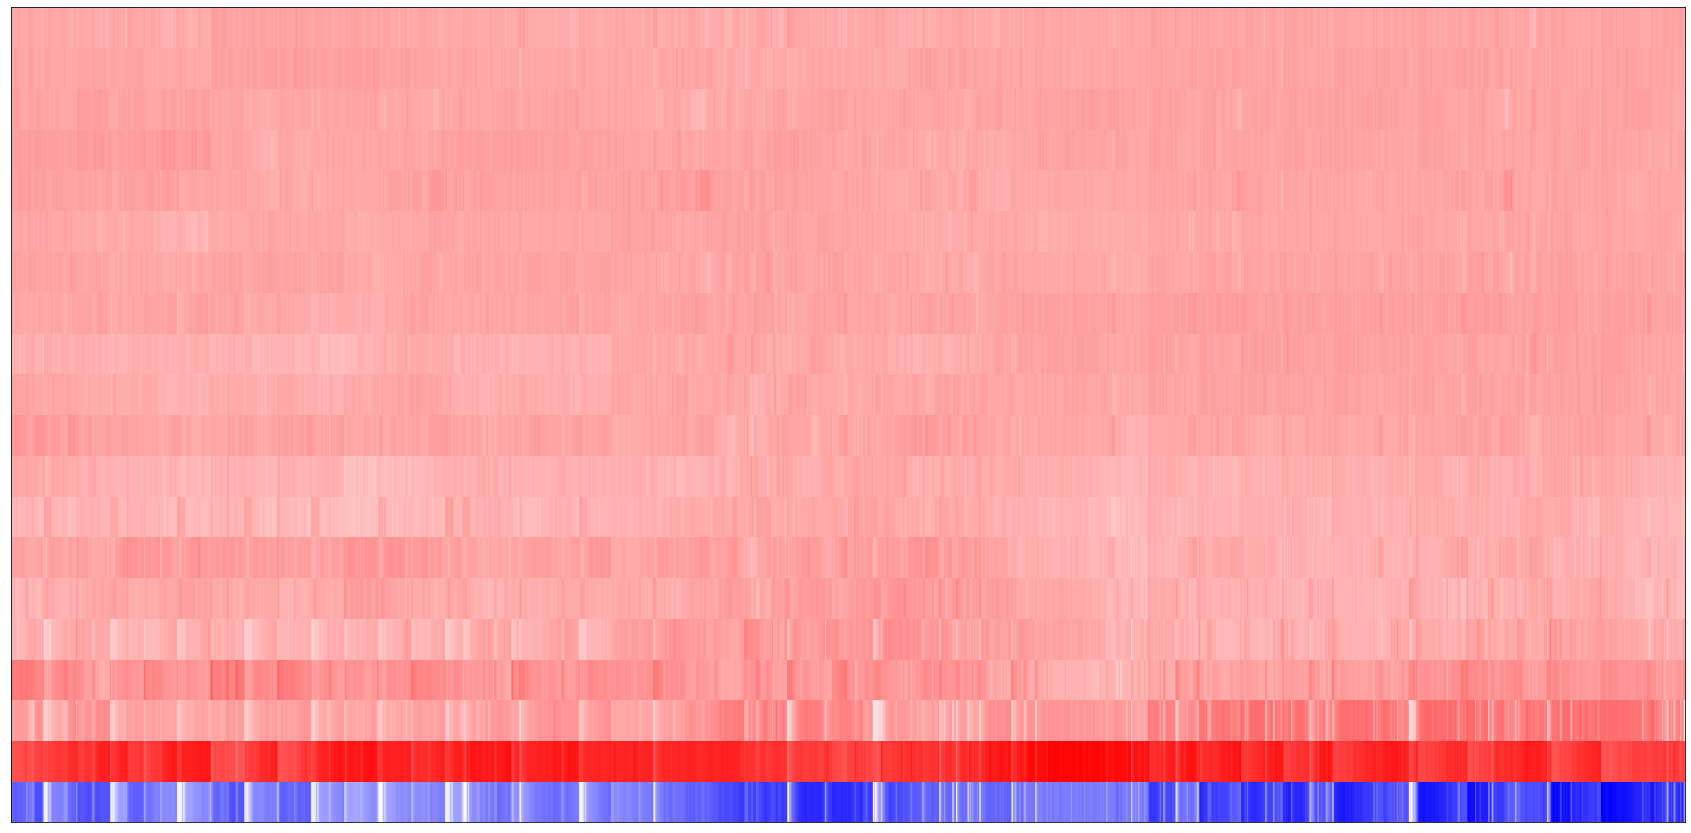

In [91]:
fig = plt.figure(figsize = (30, 15))
librosa.display.specshow(mfcc, cmap='bwr')

In [60]:
mfcc_delta = librosa.feature.delta(mfcc)

In [61]:
# look more into this
mfcc_delta.shape

(20, 2812)

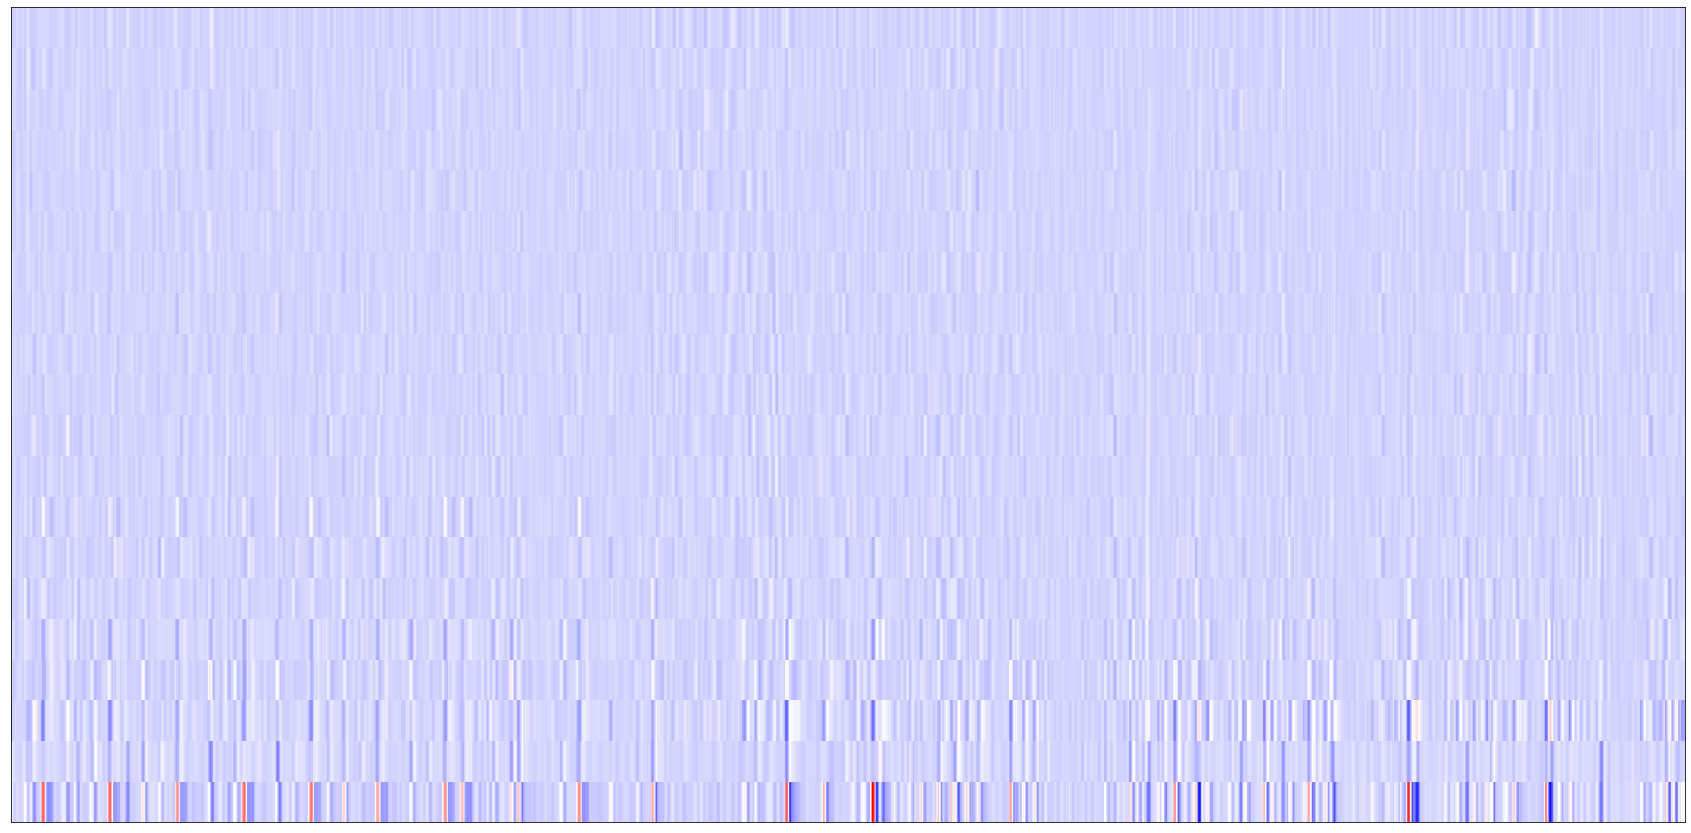

In [93]:
fig = plt.figure(figsize = (30, 15))
librosa.display.specshow(mfcc_delta, cmap='bwr')

In [63]:
y_harmonic, y_percussive = librosa.effects.hpss(y)

In [64]:
y_harmonic.shape, y_percussive.shape

((1439471,), (1439471,))

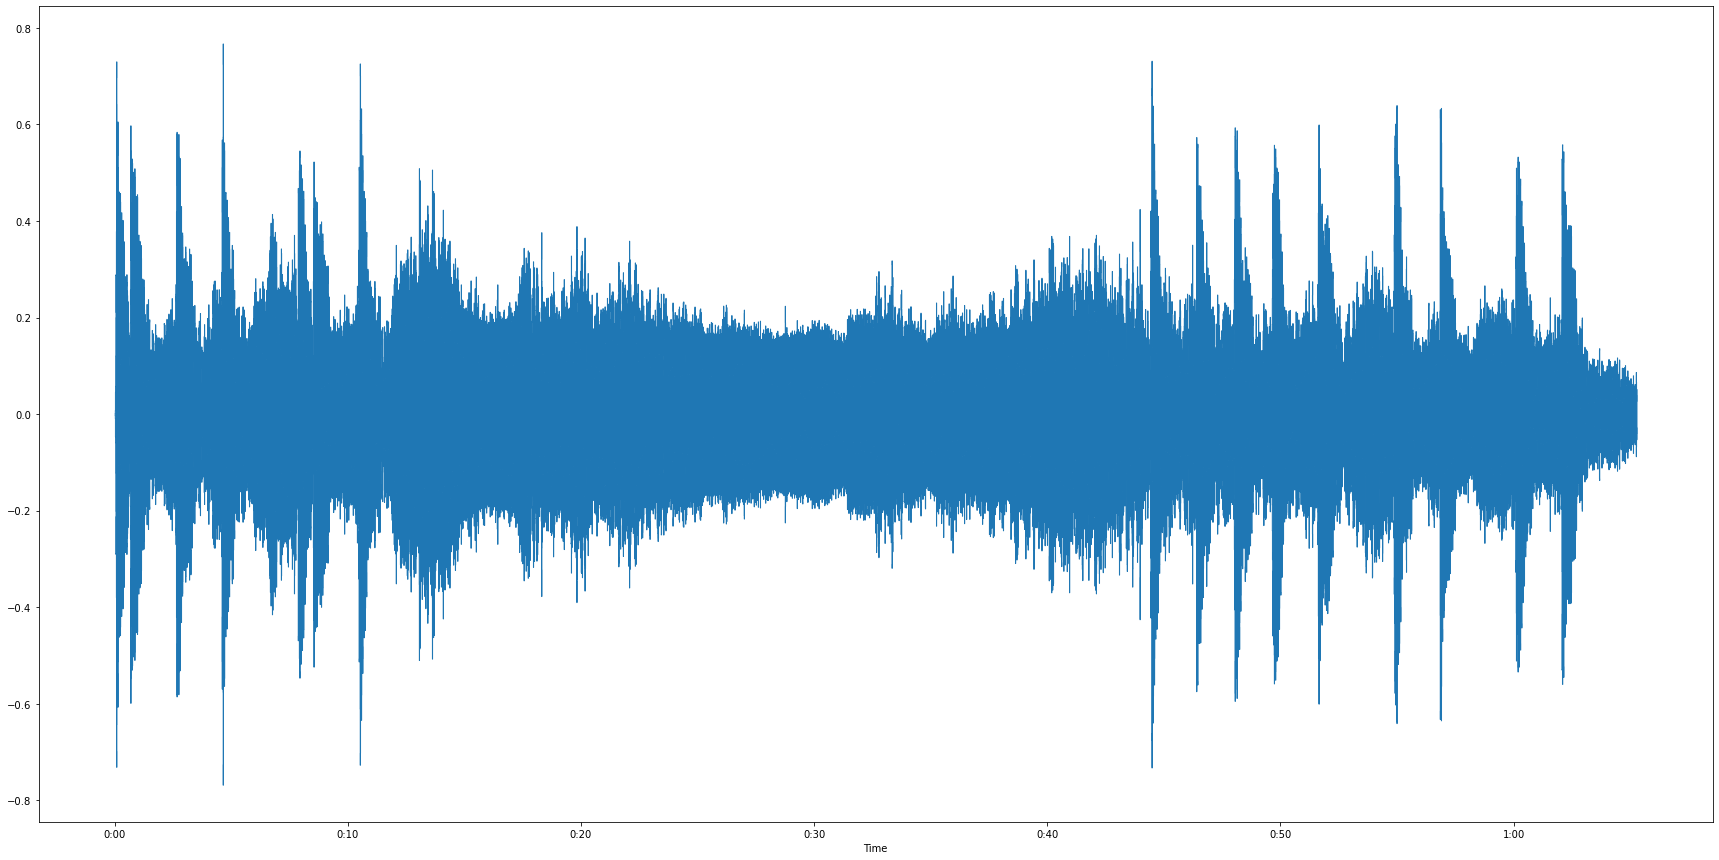

In [65]:
fig = plt.figure(figsize = (30, 15))
librosa.display.waveshow(y_harmonic)

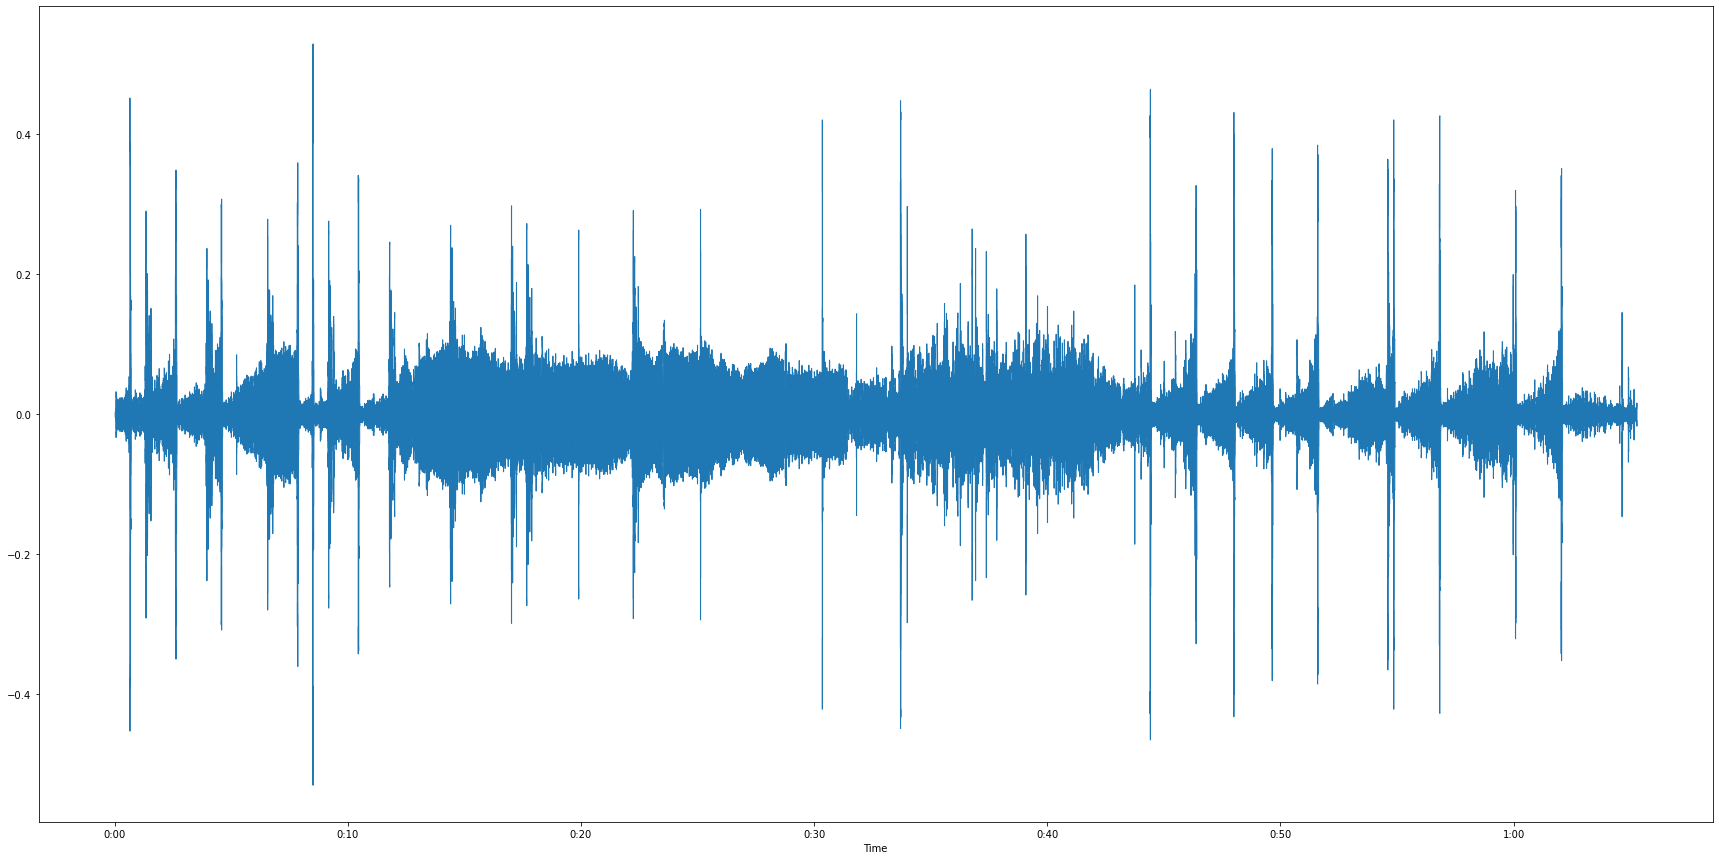

In [66]:
fig = plt.figure(figsize = (30, 15))
librosa.display.waveshow(y_percussive)

In [67]:
sf.write('percussive_test_file_48000.wav', y_percussive, 48000)

In [68]:
sf.write('harmonic_test_file_48000.wav', y_harmonic, 48000)

In [69]:
tempo, beat_frames = librosa.beat.beat_track(y=y_percussive, sr = 48000)

In [70]:
tempo

100.44642857142857

In [73]:
print(beat_frames.shape)
beat_frames

(50,)


array([   3,   57,  113,  170,  226,  282,  337,  395,  450,  507,  563,
        619,  676,  733,  795,  857,  909,  958, 1012, 1082, 1139, 1196,
       1254, 1307, 1370, 1421, 1476, 1533, 1584, 1630, 1683, 1733, 1784,
       1843, 1897, 1959, 2014, 2075, 2124, 2184, 2238, 2292, 2352, 2407,
       2463, 2529, 2583, 2635, 2689, 2743])

In [76]:
beat_mfcc_delta = librosa.util.sync(np.vstack([mfcc, mfcc_delta]), beat_frames)

In [78]:
beat_mfcc_delta.shape

(40, 51)

more filters later

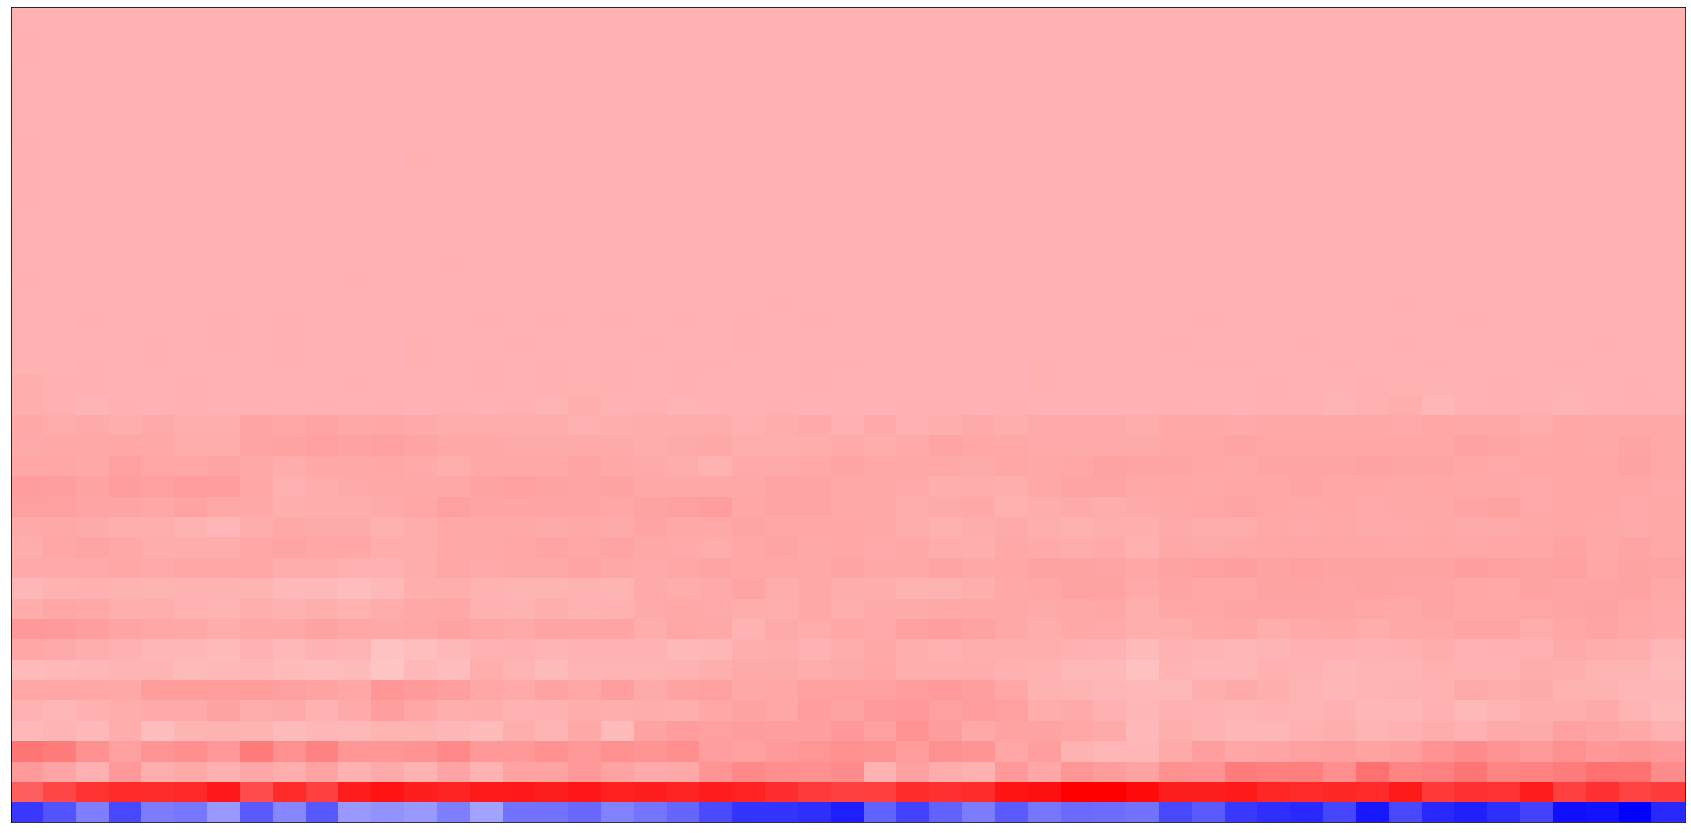

In [88]:
fig = plt.figure(figsize = (30, 15))
librosa.display.specshow(beat_mfcc_delta, cmap='bwr')

In [95]:
chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr= 48000)

In [98]:
chromagram.shape

(12, 2812)

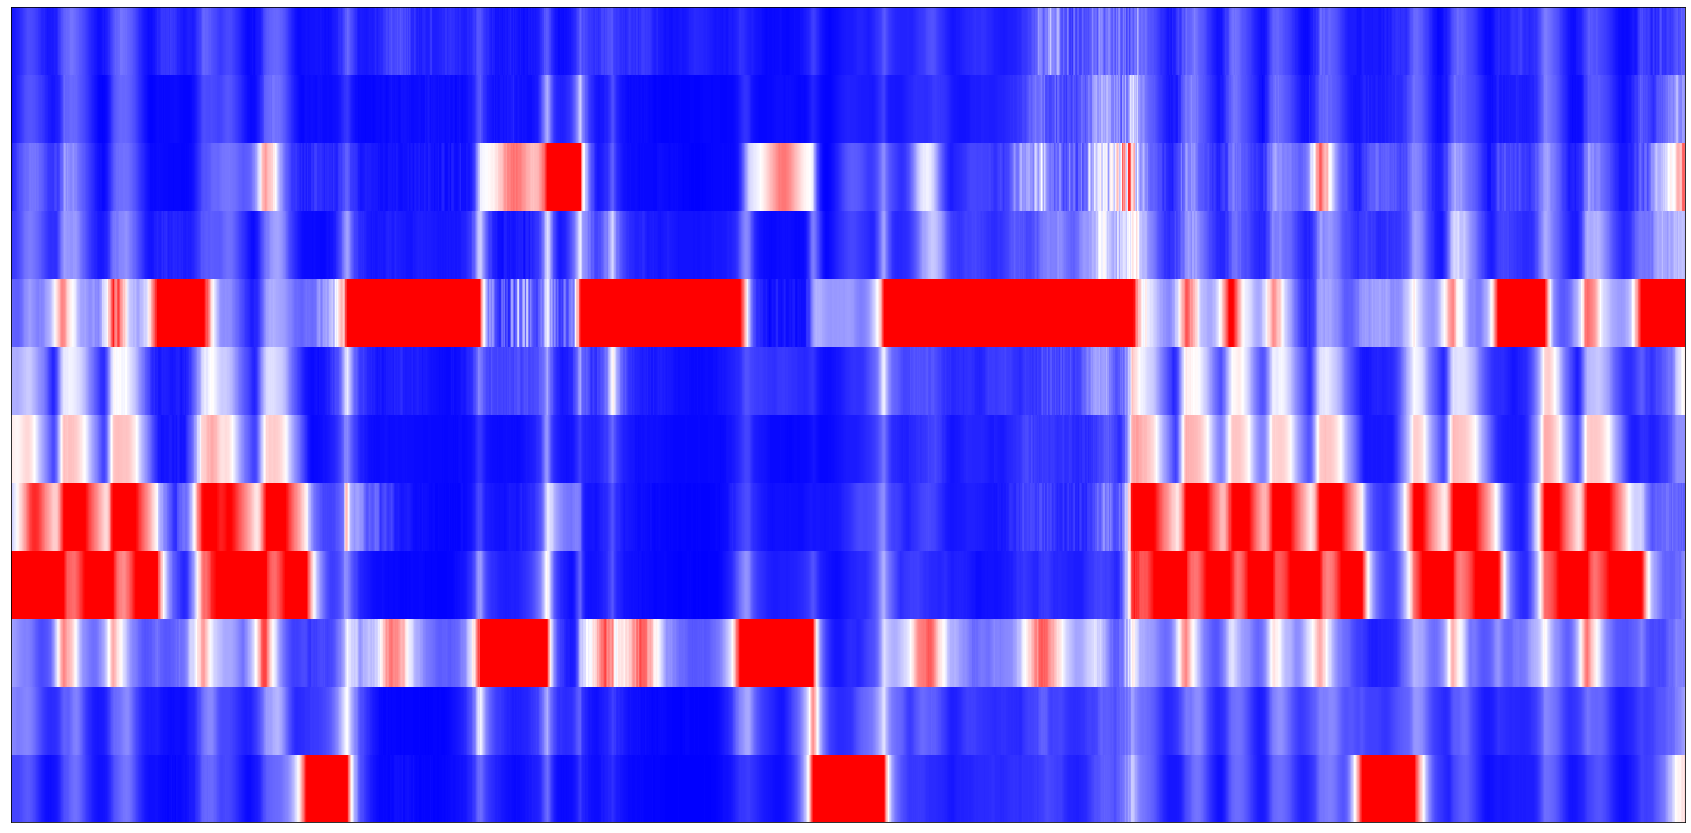

In [96]:
fig = plt.figure(figsize = (30, 15))
librosa.display.specshow(chromagram, cmap='bwr')

In [99]:
beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)

In [106]:
beat_chroma.shape

(12, 51)

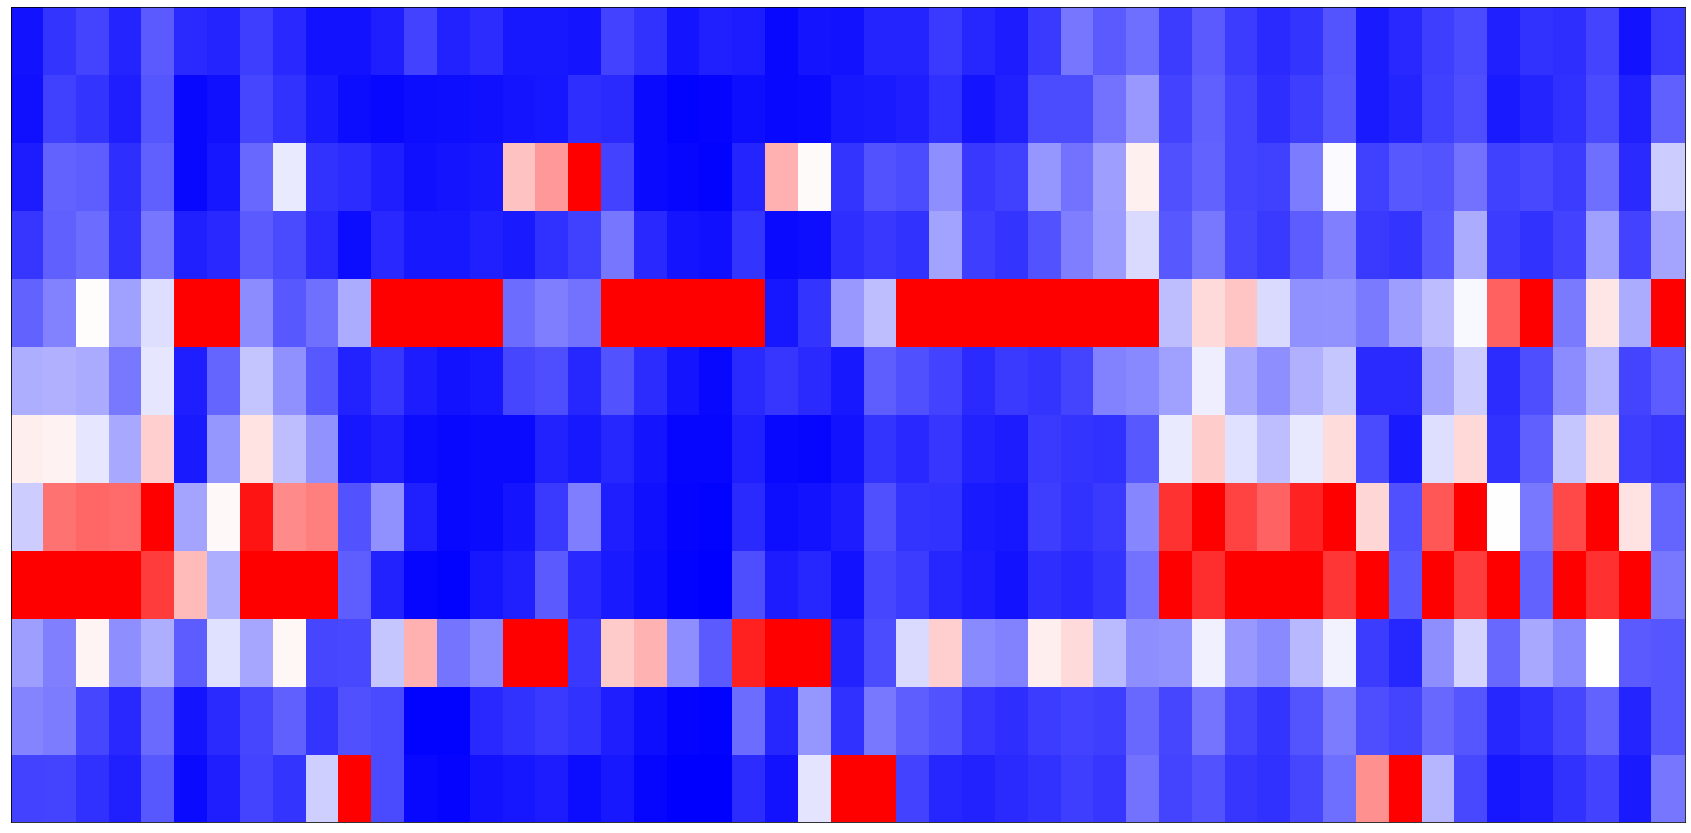

In [101]:
fig = plt.figure(figsize = (30, 15))
librosa.display.specshow(beat_chroma, cmap='bwr')

In [102]:
beat_features = np.vstack([beat_chroma, beat_mfcc_delta])

In [105]:
beat_features.shape

(52, 51)

In [104]:
pd.DataFrame(beat_features)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.140591,0.143195,0.103118,0.073659,0.182720,0.030481,0.067744,0.143341,0.112983,0.410379,...,0.718724,1.000000,0.362366,0.150746,0.052955,0.064587,0.106315,0.138361,0.061327,0.240933
1,0.268241,0.251624,0.147504,0.090298,0.214915,0.048427,0.092101,0.147165,0.197657,0.112224,...,0.161562,0.141423,0.212489,0.178161,0.085869,0.105818,0.145367,0.202202,0.081068,0.175876
2,0.315231,0.257086,0.524504,0.285720,0.348350,0.189084,0.446223,0.333543,0.520590,0.148376,...,0.128740,0.084215,0.284878,0.419671,0.210965,0.336595,0.278612,0.506896,0.185177,0.179448
3,1.000000,1.000000,1.000000,1.000000,0.881800,0.636310,0.346864,1.000000,1.000000,1.000000,...,1.000000,0.182154,1.000000,0.882403,1.000000,0.199461,1.000000,0.905861,1.000000,0.245042
4,0.404290,0.776869,0.802358,0.792786,1.000000,0.330113,0.516725,0.958284,0.729286,0.753970,...,0.583098,0.164307,0.831907,1.000000,0.501834,0.242835,0.857405,1.000000,0.561245,0.205216
5,0.538746,0.528688,0.458218,0.336409,0.601165,0.061027,0.300690,0.558972,0.379746,0.292511,...,0.155357,0.063477,0.441416,0.580075,0.109641,0.196147,0.394860,0.567653,0.130442,0.117120
6,0.349541,0.349945,0.341969,0.244826,0.454802,0.069336,0.206167,0.389500,0.288646,0.181487,...,0.091605,0.094493,0.328088,0.405336,0.095238,0.162548,0.282916,0.361043,0.141781,0.188217
7,0.200043,0.261891,0.508728,0.321712,0.442475,1.000000,1.000000,0.281811,0.181256,0.228343,...,0.246420,0.315980,0.374979,0.490328,0.813232,1.000000,0.248570,0.554804,0.345767,1.000000
8,0.117074,0.196168,0.218642,0.106623,0.237961,0.071887,0.088645,0.185300,0.152867,0.092848,...,0.125047,0.111414,0.182561,0.343713,0.125788,0.109324,0.138055,0.319564,0.138823,0.328372
9,0.065563,0.202384,0.194104,0.098748,0.198205,0.025479,0.053826,0.212908,0.463606,0.108947,...,0.135583,0.183011,0.175663,0.231772,0.133710,0.149412,0.128276,0.225066,0.091169,0.405565
